In [4]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate, interpolate
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd

import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 16})

In [7]:
###################################################################
# Simulation Functions
###################################################################

#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE_simple(y, t,params):
    A = y
    k,delta = params
    
    dA = k - delta*A

#     derivs = [dA,dB]
    return dA

#determine homogenous SS using ssODE
def homogenousSS_simple(params):

    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE_simple,0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def logistic_decay(x,p_min,p_max,k,x0=1.75):  
    #positive k -> decay
    p_amp = p_max - p_min
    return p_min+p_amp/(1+np.exp(k*(x-x0)))

def simple_diffusion(params):
    k_s,k_p,delta,Du = params

    #Bases:names,modes,intervals,dealiasing
    r_basis=de.Chebyshev('r',1024,interval=(0,4),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([r_basis],float)
    r = domain.grids(scales=1)
    
    mu_F = 1.75

    k = domain.new_field(name='k')

    k['g'] = [k_p if curr_r < mu_F else k_s for curr_r in r[0]]

    p_ss = [k_s,delta]
    u0 = homogenousSS_simple(p_ss)


    # Specify problem
    problem = de.IVP(domain, variables=['u', 'ur'])

    problem.parameters['k'] = k
    problem.parameters['Du'] = Du
    problem.parameters['delta'] = delta

    problem.substitutions['f(u)'] = 'k - delta*u'
    problem.substitutions['minf(u)'] = '-f(u)'


    problem.add_equation("r*dt(u)-r*Du*dr(ur)-Du*dr(u)=r*f(u)")

    problem.add_equation("ur-dr(u)=0")


    # # Neumann boundary conditions
    problem.add_bc("left (ur) = 0")
    problem.add_bc("right (ur) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #RK222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    
    u['g'] = u0

    solver.stop_iteration = 1000 #200

    dt = 0.01 #0.25
    nonan = True
    # curr_t = 0
    # Main loop chceking stopping criteria
    while solver.ok and nonan:
        # Step forward
        solver.step(dt)
        # curr_t += dt

        if solver.iteration % 5 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                print('Numerical Error')
                print(params)
                return('Numerical Error')
                nonan = False 
                
    return u['g']

In [12]:
r_basis=de.Chebyshev('r',1024,interval=(0,4),dealias=3/2)
#Domain:bases,datatype
#     domain=de.Domain([phi_basis,r_basis],float)
domain=de.Domain([r_basis],float)
r = domain.grids(scales=3/2)

In [26]:
mu_F = 1.75


k_s = 0.25
k_p = 1
delta = 0.75

k_vals =  exp_decay_gradient(k_s,k_p,10e6,r[0],mu_F)

In [27]:
#simulate model for various diffusion rates

params = (k_s,k_p,delta,0.001)
u = simple_diffusion(params)
params2 = (k_s,k_p,delta,0.01)
u2 = simple_diffusion(params2)
params3 = (k_s,k_p,delta,0.1)
u3 = simple_diffusion(params3)
params4 = (k_s,k_p,delta,1)
u4 = simple_diffusion(params4)

params5 = (k_s,k_p,delta,10)
u5 = simple_diffusion(params5)

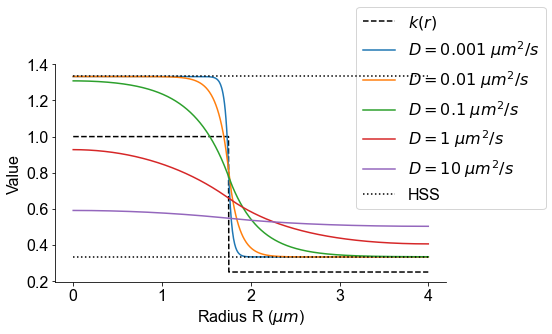

In [31]:
plt.figure(figsize=(7,4))
plt.plot(r[0],k_vals,'k--')

plt.plot(r[0],u)
plt.plot(r[0],u2)
plt.plot(r[0],u3)
plt.plot(r[0],u4)
plt.plot(r[0],u5)

plt.hlines(k_p/delta,0,4,'k',':',zorder=10)
plt.hlines(k_s/delta,0,4,'k',':',zorder=10)

plt.ylabel('Value')
plt.xlabel('Radius R ($\mu m$)')
plt.yticks([0.2,0.4,0.6,0.8,1.0,1.2,1.4])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(['$k(r)$', '$D = 0.001$ $\mu m^2/s$','$D = 0.01$ $\mu m^2/s$','$D = 0.1$ $\mu m^2/s$','$D = 1.$ $\mu m^2/s$','$D = 10.$ $\mu m^2/s$','HSS'],loc='center left', bbox_to_anchor=(0.75, 0.8))

# plt.savefig('SimpleDiffFigures/SimpleDiffSims.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('SimpleDiffFigures/SimpleDiffSims.png',bbox_inches='tight',dpi=300)


In [361]:
#simulate model for various diffusion rates

Dus = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]
all_u_sims = []
for Du in Dus:
    params = (k_s,k_p,delta,Du)
    u = simple_diffusion(params)
    all_u_sims.append(u)

(0.0, 1.5)

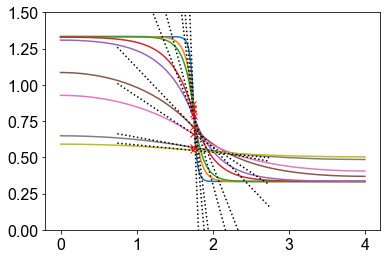

In [362]:
# Get the maximum slope and %increase for each distributions

max_slopes = []
percent_increase = []

for curr_u in all_u_sims:

    u_interp = np.array(scipy.interpolate.griddata(r[0],curr_u,rs))
    plt.plot(rs,u_interp)

    u_grad = np.gradient(u_interp)

    # plt.plot(rs,u3_grad)

    # plt.xlim([1.5,2])
    # plt.ylim([-2,2])
    slope_u = np.min(np.nan_to_num(u_grad))/(rs[1]-rs[0])
    
    slope_loc = np.argmin(np.nan_to_num(u_grad))

    # plt.axline((1.75, rs[np.argmin(np.abs(rs-1.75))]), slope=slope_u3, linewidth=4, color='r')

    x_mid = rs[slope_loc]
    y_mid = u_interp[slope_loc]
    xs = np.array([x_mid-1,x_mid+1])
    ys =np.array([y_mid-slope_u, y_mid+slope_u])
    plt.plot(xs,ys,'k:')
    plt.plot(x_mid, y_mid,'rx')
    
    curr_perc_inc = 100*(np.max(curr_u)-np.min(curr_u))/np.min(curr_u)
    
    max_slopes.append(slope_u)
    percent_increase.append(curr_perc_inc)

plt.ylim([0,1.5])

In [ ]:
color1 = my_color1 = [16 127 128]/255;
    my_color2 = [178 2 98]/255;

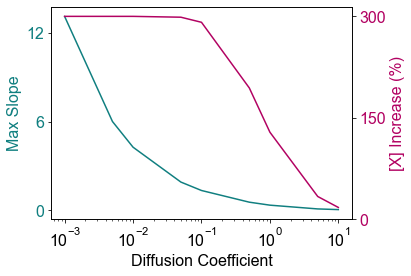

In [387]:
#Plot max slop and %increase for different diffusion coefficients

fig, ax1 = plt.subplots(figsize=(6,4))

color = np.array([16, 127, 128])/255
ax1.set_xlabel('Diffusion Coefficient')
ax1.set_ylabel('Max Slope', color=color)
ax1.plot(Dus,-np.array(max_slopes) , color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0,6,12])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = np.array([178, 2, 98])/255
ax2.set_ylabel('[X] Increase (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(Dus,percent_increase, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0,150,300])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xscale('log')
plt.xticks([1e-3,1e-2,1e-1,1e-0,1e1])
# plt.savefig('SimpleDiffFigures/SimpleDiffChanges.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('SimpleDiffFigures/SimpleDiffChanges.png',bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
## Optimization used to determine best fits to logistic function

# from scipy.optimize import minimize

# def model_logistic_decay(params):
#     p_max, p_min,k = params
#     y_pred = logistic_decay(r[0],p_max, p_min,k,x0=1.75)
#     return np.array(y_pred)

# def sum_of_squares(params, Y):
#     y_pred = model_logistic_decay(params)
#     obj = np.sqrt(((y_pred - Y) ** 2).sum())
#     return obj

# # # generate some test data
# # X = (0.33,1.33,30) 
# # Y = np.array(u5)

# # bnds = ((0.1,20), (0.1, 20), (1,50))

# # res = minimize(sum_of_squares, [X, ], args=(Y), tol=10e-20,bounds = bnds, method="SLSQP")
# # print(res)

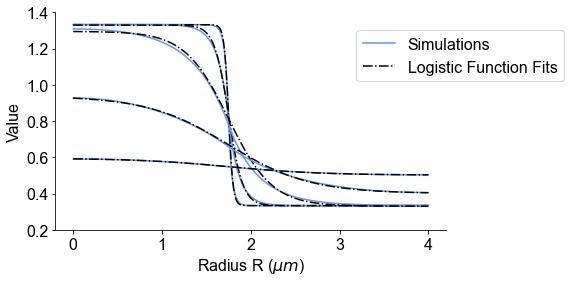

In [30]:
#Plot logistic function fits to distributions

plt.figure(figsize=(7,4))
# plt.plot(r[0],k_vals,'k--')

plt.plot(r[0],u,'cornflowerblue')
plt.plot(r[0],logistic_decay(r[0],0.33338773,  1.33212728, 39.37514704),'k-.')
plt.plot(r[0],u2,'cornflowerblue')
plt.plot(r[0],logistic_decay(r[0],0.33313447,  1.32992236, 12.45081017),'k-.')
plt.plot(r[0],u3,'cornflowerblue')
plt.plot(r[0],logistic_decay(r[0],0.33060365, 1.29511316, 4.07937945),'k-.')
plt.plot(r[0],u4,'cornflowerblue')
plt.plot(r[0],logistic_decay(r[0],0.4006764 , 0.93771764, 2.19901158),'k-.')
plt.plot(r[0],u5,'cornflowerblue')
plt.plot(r[0],logistic_decay(r[0],0.50189141, 0.59474728, 1.91201805),'k-.')

plt.ylabel('Value')
plt.xlabel('Radius R ($\mu m$)')
plt.yticks([0.2,0.4,0.6,0.8,1.0,1.2,1.4])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(['Simulations', 'Logistic Function Fits'],loc='center left', bbox_to_anchor=(0.75, 0.8))

# plt.savefig('SimpleDiffFigures/SimpleDiffLogisticFits.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('SimpleDiffFigures/SimpleDiffLogisticFits.png',bbox_inches='tight',dpi=300)
plt.show()

### Successful Fully Coupled Model after MCMC Sampling

In [8]:
params1 = [6.80749853e-01, 1.13064963e+01, 6.95777447e+00, 3.54645570e-02]
params2 = [9.93217567e-06, 6.32505567e+00, 5.05504221e+00, 4.21203150e+00]

In [9]:
rs = np.linspace(0,4,1000)

#Results from original MCMC using the logistic function approximation 
mean_chain_logistic_c = logistic_decay(rs,0.1,1.58414687, 12.89118133)
mean_chain_logistic_gamma = logistic_decay(rs,0.0005,0.96046689, 2.04555275)

In [10]:
best_coupled_c= simple_diffusion(params1)
best_coupled_gamma = simple_diffusion(params2)

/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/macowner/opt/anaconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


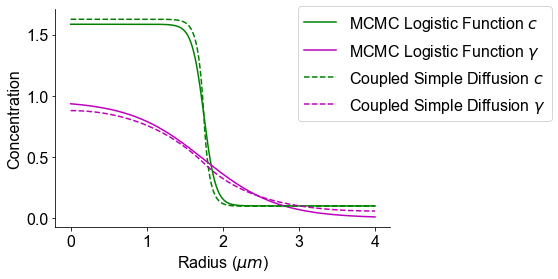

In [13]:
plt.figure(figsize=(6,4))

plt.plot(rs,mean_chain_logistic_c,'g')
plt.plot(rs,mean_chain_logistic_gamma,'m')

plt.plot(r[0],best_coupled_c,'g--')
plt.plot(r[0],best_coupled_gamma,'m--')

plt.ylabel('Concentration')
plt.xlabel('Radius ($\mu m$)')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(['MCMC Logistic Function $c$','MCMC Logistic Function $\gamma$',
           'Coupled Simple Diffusion $c$','Coupled Simple Diffusion $\gamma$'],loc='center left', bbox_to_anchor=(0.7, 0.75))

# plt.savefig('CoupledModel_vsLogisticMCMC.pdf',bbox_inches='tight',dpi=300)
# plt.savefig('CoupledModel_vsLogisticMCMC.png',bbox_inches='tight',dpi=300)

